# 5 Hole probe Calibration using ML
This is an example for developing a ML model for 5 Hole NASA Probe. It's not as well documented as the Aerodyne probe which comes with a presentation in addition to the CSV Files.

## Why use Machine Learning
5 Hole probes contain readings from 5 different pressure transducers. The calibration procedure involves testing them against a jet where the probe head is rotated in the pitch and yaw directions.

This produces lots of data:
Pressure Readings
- Hole 1 (P1, FAP1)
- Hole 2 (P2,FAP2)
- Hole 3 (P3,FAP3)
- Hole 4 (P4,FAP4)
- Hole 5 (P5,FAP5)
- Ambient/Static (Pa, FAP6)

Other Data
- Yaw and Pitch from calibration machine.
- Mach Number: function of P0/P

<div>
<img src="https://github.com/nasa/multihole-probe-calibration/blob/main/tutorials/5HoleProbe/images/5-hole%20probe.jpg?raw=1" style="height:300px" />
</div>


## Processing Data
The data is stored in a csv file. The headers we are interested in are **FAP2-FAP6**. *This is what we are training on.*

What we are predicted are **YAW**, **PITCH**, **MFJ**, **PTFJ**

> **_NOTE:_**  The data are in pressures which have units. Machine learning optimizes coefficients in a matrix. Data that isn't normalized can create illconditioned matrices


### Normalizing the Data
Nondimensioning the data to be 0 and 1 helps the training process converge much quicker. 4 nondimensional coefficients were created from the dataset.
FA



<img src="https://github.com/nasa/multihole-probe-calibration/blob/main/tutorials/5HoleProbe/images/normalization_mhp.png?raw=1" style="width:600px"/>


### Placing Functions into Memory
The code to normalize the data is shown below. Here's a brief description of each of the code blocks.

1. **Import headers**: All external codes that are required.
2. **Create Coefficients**: Create the coefficients
3. **Create Data Loaders**: Required to load data in batch format to pytorch model for training
4. **TrainMultilayer**: Code to train and save the MultiLayer Network
5. **TrainKanNetwork**: Code to train and save the KAN Network


In [1]:
!git clone https://github.com/nasa/multihole-probe-calibration.git
!cp -r multihole-probe-calibration/* .
!rm -r multihole-probe-calibration
!cp -r tutorials/5HoleProbe .

Cloning into 'multihole-probe-calibration'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 310 (delta 10), reused 305 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (310/310), 13.04 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (10/10), done.
cp: cannot stat 'tutorials/5HoleProbe': No such file or directory


In [ ]:
import sys, os
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from multihole_probe import NeuralNet_MultiLayer, KAN
from multihole_probe.train_model import train_model
from sklearn.preprocessing import MinMaxScaler
import torch


In [ ]:
def CreateCoefficients(df:pd.DataFrame):
    """Create the coefficients for model 1 and model 2

    Args:
        df (pd.DataFrame): dataframe containing probe data
    """
    FAP2 = df['FAP2'].values	# Hole 5, Center Hole
    FAP3 = df['FAP3'].values	# Hole 1
    FAP4 = df['FAP4'].values    # Hole 2
    FAP5 = df['FAP5'].values    # Hole 3
    FAP6 = df['FAP6'].values    # Hole 4
    Pt = df['PTFJ'].values
    Ps = df['PSFJ'].values
    # Predicted
    theta = df['YAW'].values 	# Model 1
    phi = df['PITCH'].values 	# Model 1
    mach = df['MFJ'].values		# Model 2
    Cpt = (FAP2-Ps) / (Pt-Ps) 	# Model 2
    # Used to train model to predicted values of Theta, Phi, Mach, Cpt
    Pavg = 0.25 * (FAP3 + FAP4 + FAP5 + FAP6)
    Cp1 = (FAP3-Pavg)/(FAP2-Pavg)
    Cp2 = (FAP4-Pavg)/(FAP2-Pavg)
    Cp3 = (FAP5-Pavg)/(FAP2-Pavg)
    Cp4 = (FAP6-Pavg)/(FAP2-Pavg)
    Cpm = (FAP2-Pavg)/(FAP2)

    data = np.stack([Cp1,Cp2,Cp3,Cp4,Cpm,theta,phi]).transpose()
    model1_data = pd.DataFrame(data=data, index=np.arange(0,len(Cp1)), columns=['Cp1','Cp2','Cp3','Cp4','Cpm','theta','phi'])

    data = np.stack([Cp1,Cp2,Cp3,Cp4,Cpm,mach,Cpt]).transpose()
    model2_data = pd.DataFrame(data=data, index=np.arange(0,len(Cp1)), columns=['Cp1','Cp2','Cp3','Cp4','Cpm','mach','Cpt'])

    return model1_data, model2_data

In [ ]:
def CreateDataLoaders(in_features:int):
    """Read in the data and create the torch data loaders

    Args:
        in_features (int): number of input features

    Returns:
        (Tuple) containing:

            *model1_train_loader* (DataLoader): DataLoader to predict Theta and Phi
            *model1_test_loader* (DataLoader): DataLoader to validate Theta and Phi
            *model2_train_loader* (DataLoader): DataLoader to predict Mach and Cpt
            *model2_test_loader* (DataLoader): DataLoader to validate Mach and Cpt

    """
    data = pickle.load(open('checkpoints/01_5HoleProbe_data.pkl', 'rb'))

    # Multi-layer perception

    model1_x_train = data['model1']['train'][:,:in_features]
    model1_y_train = data['model1']['train'][:,in_features:]
    model1_x_test = data['model1']['test'][:,:in_features]
    model1_y_test = data['model1']['test'][:,in_features:]

    model2_x_train = data['model2']['train'][:,:in_features]
    model2_y_train = data['model2']['train'][:,in_features:]
    model2_x_test = data['model2']['test'][:,:in_features]
    model2_y_test = data['model2']['test'][:,in_features:]

    model1_train_dataset = torch.utils.data.TensorDataset(torch.tensor(model1_x_train).float(),torch.tensor(model1_y_train).float())
    model1_test_dataset = torch.utils.data.TensorDataset(torch.tensor(model1_x_test).float(),torch.tensor(model1_y_test).float())

    model2_train_dataset = torch.utils.data.TensorDataset(torch.tensor(model2_x_train).float(),torch.tensor(model2_y_train).float())
    model2_test_dataset = torch.utils.data.TensorDataset(torch.tensor(model2_x_test).float(),torch.tensor(model2_y_test).float())

    model1_train_loader = torch.utils.data.DataLoader(dataset=model1_train_dataset,batch_size=64)
    model1_test_loader = torch.utils.data.DataLoader(dataset=model1_test_dataset,batch_size=64)

    model2_train_loader = torch.utils.data.DataLoader(dataset=model2_train_dataset,batch_size=64)
    model2_test_loader = torch.utils.data.DataLoader(dataset=model2_test_dataset,batch_size=64)
    return model1_train_loader, model1_test_loader, model2_train_loader, model2_test_loader

In [ ]:

def TrainMultiLayer(in_features:int,out_features:int,hidden_layers:int):
    """Train a standard DNN Network

    Args:
        in_features (int): Number of inputs
        out_features (int): Number of outputs
        hidden_layers (int): Size of hidden layers. Example, [8,8,8,8] 4 layers with 8 neurons per layer


    Returns:
        Dict: Dictionary containing the model states and training and validation loss history

    """
    nn_model1 = NeuralNet_MultiLayer(in_features,hidden_layers,out_features)
    nn_model2 = NeuralNet_MultiLayer(in_features,hidden_layers,out_features)

    model1_train_loader, model1_test_loader, model2_train_loader, model2_test_loader = CreateDataLoaders(in_features)

    nn_model1,training_loss_history1,validation_loss_history1 = train_model(nn_model1,model1_train_loader,model1_test_loader,num_epochs=2000,verbose=True)
    nn_model2,training_loss_history2,validation_loss_history2 = train_model(nn_model2,model2_train_loader,model2_test_loader,num_epochs=2000,verbose=True)

    return {'nn_model1': nn_model1.state_dict(),
            'nn_training_loss_history1':training_loss_history1,
            'nn_validation_loss_history1':validation_loss_history1,
            'nn_model2': nn_model2.state_dict(),
            'nn_training_loss_history2':training_loss_history2,
            'nn_validation_loss_history2':validation_loss_history2,
            'in_features':in_features,
            'out_features':out_features,
            'hidden_layers':hidden_layers
            }


def TrainKanNetwork(in_features:int,out_features:int,hidden_layers:int):
    """Train the KAN Network

    https://github.com/Blealtan/efficient-kan/tree/master

    Args:
        in_features (int): Number of inputs
        out_features (int): Number of outputs
        hidden_layers (int): Size of hidden layers. Example, [8,8,8,8] 4 layers with 8 neurons per layer

    Returns:
        Dict: Dictionary containing the model states and training and validation loss history

    """
    kan_layers = [in_features]; kan_layers.extend(hidden_layers); kan_layers.append(out_features)
    kan_model1 = KAN(kan_layers)
    kan_model2 = KAN(kan_layers)

    model1_train_loader, model1_test_loader, model2_train_loader, model2_test_loader = CreateDataLoaders(in_features)

    kan_model1,training_loss_history1,validation_loss_history1 = train_model(kan_model1,model1_train_loader,model1_test_loader,num_epochs=2000,verbose=True)
    kan_model2,training_loss_history2,validation_loss_history2 = train_model(kan_model2,model2_train_loader,model2_test_loader,num_epochs=2000,verbose=True)


    return {'KAN_model1': kan_model1.state_dict(),
            'KAN_training_loss_history1':training_loss_history1,
            'KAN_validation_loss_history1':validation_loss_history1,
            'KAN_model2': kan_model2.state_dict(),
            'KAN_training_loss_history2':training_loss_history2,
            'KAN_validation_loss_history2':validation_loss_history2
            }



## Step 1 Processing the Data
Now that we have placed all the functions into memory it's time to run the code to process the data. For this example, we are using Probe 1. The 2 code blocks below create a file in the checkpoint folder. This file contains the dataloaders along with the minmax scalers.

In [ ]:

def Step1_ProcessData():
    """Process the data into test and train for both models
    """
    # Specifies what data points to use based on calibration data.
    # Probe caller specifies the probe. Total 10 probes
    probe_caller = 1
    if probe_caller   == 1:
        probe_loc = [0,1805] # Reading numbers corresponding to different Probes
    elif probe_caller == 2:
        probe_loc = [1806,3609]
    elif probe_caller == 3:
        probe_loc = [3610,5414]
    elif probe_caller == 4:
        probe_loc = [5415,7219]
    elif probe_caller == 5:
        probe_loc = [7220,9026]
    elif probe_caller == 6:
        probe_loc = [9027,10831]
    elif probe_caller == 7:
        probe_loc = [10832,12641]
    elif probe_caller == 8:
        probe_loc = [12642,14447]
    elif probe_caller == 9:
        probe_loc = [14448,16252]
    elif probe_caller == 10:
        probe_loc = [16253,18061]

    #%% Read in the data
    df = pd.read_csv('dataset/5Hole-Probe1.csv')
    # Select from datapoints
    probe_1 = df.iloc[probe_loc[0]:probe_loc[1]]
    # validation_set = probe_1.query('MFJ<0.55 and MFJ>0.45')
    # test_train_set = probe_1.query('MFJ>0.55 or MFJ<0.45')

    model1_data,model2_data = CreateCoefficients(df=probe_1)
    minmax_model1 = MinMaxScaler(feature_range=(-1, 1))
    minmax_model2 = MinMaxScaler(feature_range=(-1, 1))
    minmax_model1.fit(model1_data)
    minmax_model2.fit(model2_data)
    model1_data = minmax_model1.transform(model1_data)
    model2_data = minmax_model2.transform(model2_data)

    train1,test1 = train_test_split(model1_data,test_size=0.2)
    train2,test2 = train_test_split(model2_data,test_size=0.2)

    os.makedirs('checkpoints',exist_ok=True)
    os.makedirs('results',exist_ok=True)

    pickle.dump({
                    'model1':
                        {
                            'data':model1_data,
                            'train':train1,
                            'test':test1,
                            'minmax':minmax_model1
                        },
                    'model2':
                        {
                            'data':model2_data,
                            'train':train2,
                            'test':test2,
                            'minmax':minmax_model2
                        }
                },
                open('checkpoints/01_5HoleProbe_data.pkl','wb'))

In [ ]:
Step1_ProcessData()

## Training the Models
The code below trains the Neural Network and KAN Models. Try changing the hidden_layer size to see if accuracy could be improved.

In [ ]:
def Step2_TrainModels():
    """Build the models and train them
    """
    in_features = 5; out_features = 2 # For both model 1 and 2
    hidden_layers = [64,64,64,64]
    nn_data = TrainMultiLayer(in_features,out_features,hidden_layers)
    kan_data = TrainKanNetwork(in_features,out_features,hidden_layers)

    pickle.dump(dict(nn_data, **kan_data),
                open('checkpoints/02_5HoleProbe_Trained_Models.pkl','wb'))

In [ ]:
Step2_TrainModels()

Epoch [1/2000] Train Loss: 8.39e-02, Validation Loss 2.18e-02, Min Loss 1.01e-02, Max Loss 2.49e-01
Epoch [2/2000] Train Loss: 6.06e-03, Validation Loss 3.46e-03, Min Loss 1.52e-03, Max Loss 2.03e-02
Epoch [3/2000] Train Loss: 1.32e-03, Validation Loss 1.16e-03, Min Loss 4.95e-04, Max Loss 3.34e-03
Epoch [4/2000] Train Loss: 5.64e-04, Validation Loss 8.54e-04, Min Loss 3.38e-04, Max Loss 1.21e-03
Epoch [5/2000] Train Loss: 4.04e-04, Validation Loss 6.18e-04, Min Loss 1.88e-04, Max Loss 8.47e-04
Epoch [6/2000] Train Loss: 2.96e-04, Validation Loss 3.85e-04, Min Loss 1.40e-04, Max Loss 5.94e-04
Epoch [7/2000] Train Loss: 2.20e-04, Validation Loss 3.86e-04, Min Loss 1.38e-04, Max Loss 3.37e-04
Epoch [8/2000] Train Loss: 2.12e-04, Validation Loss 4.93e-04, Min Loss 1.04e-04, Max Loss 3.50e-04
Epoch [9/2000] Train Loss: 2.36e-04, Validation Loss 2.33e-04, Min Loss 9.64e-05, Max Loss 4.44e-04
Epoch [10/2000] Train Loss: 1.44e-04, Validation Loss 2.72e-04, Min Loss 9.00e-05, Max Loss 2.29e-04

## Inference
Inference is used to read in the machine learning model and report the output. Think of it as a query or user interface to the machine learning model.

The user will supply the Pressures from the probe read out FAP1-5 for all the holes with FAP1 being the first hole. The inference code will take this data and compute all the `Cp` coefficients and plug into the ML model 1 and model 2. Model 1 predicts the `theta` and `phi`. Model 2 predicts `Mach` and `Cpt`

In [ ]:
import sys
import pickle
from typing import Union
from multihole_probe import NeuralNet_MultiLayer, KAN
import numpy.typing as npt
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

### Inference Code: `predict_data`

In [ ]:

def predict_data(FAP1:Union[float,npt.NDArray],FAP2:Union[float,npt.NDArray],
                 FAP3:Union[float,npt.NDArray],FAP4:Union[float,npt.NDArray],
                 FAP5:Union[float,npt.NDArray], Ps:Union[float,npt.NDArray]):
    """Predicts the data

    Args:
        FAP1 (Union[float,npt.NDArray]): Hole 1, Center Hole
        FAP2 (Union[float,npt.NDArray]): Hole 2
        FAP3 (Union[float,npt.NDArray]): Hole 3
        FAP4 (Union[float,npt.NDArray]): Hole 4
        FAP5 (Union[float,npt.NDArray]): Hole 5
        Ps (Union[float,npt.NDArray]): Static Pressure

    Outputs:
        nn_out1: theta, phi angles unnormalized using Multilayer Perception Network (stacked linear layers)
        nn_out2: mach, cpt unnormalized using Multilayer Perception Network (stacked linear layers)
        kan_out1: theta, phi angles unnormalized using KAN network
        kan_out2: mach and cpt unnormalized using KAN network
    """
    # Process the Data
    data = pickle.load(open('checkpoints/01_5HoleProbe_data.pkl','rb'))
    model1_minmax = data['model1']['minmax']
    model2_minmax = data['model2']['minmax']
    Pavg = 0.25 * (FAP2 + FAP3 + FAP4 + FAP5)
    Cp1 = (FAP2-Pavg)/(FAP1-Pavg)
    Cp2 = (FAP3-Pavg)/(FAP1-Pavg)
    Cp3 = (FAP4-Pavg)/(FAP1-Pavg)
    Cp4 = (FAP5-Pavg)/(FAP1-Pavg)
    Cpm = (FAP1-Pavg)/(FAP1)

    input = torch.tensor(np.stack([Cp1,Cp2,Cp3,Cp4,Cpm,Cp1*0,Cp1*0]).transpose())
    model1_minmax.fit(input)
    input = input.float()

    # Build the model
    model_data = pickle.load(open('checkpoints/02_5HoleProbe_Trained_Models.pkl','rb'))

    nn_model1 = NeuralNet_MultiLayer(model_data['in_features'],
                        model_data['hidden_layers'],
                        model_data['out_features'])
    nn_model2 = NeuralNet_MultiLayer(model_data['in_features'],
                        model_data['hidden_layers'],
                        model_data['out_features'])

    kan_layers = [model_data['in_features']]; kan_layers.extend(model_data['hidden_layers']); kan_layers.append(model_data['out_features'])
    kan_model1 = KAN(kan_layers)
    kan_model2 = KAN(kan_layers)

    nn_model1.load_state_dict(model_data['nn_model1'])
    nn_model2.load_state_dict(model_data['nn_model2'])
    kan_model1.load_state_dict(model_data['KAN_model1'])
    kan_model2.load_state_dict(model_data['KAN_model2'])

    # Predict the Data
    nn_out1 = nn_model1(input[:,:model_data['in_features']])
    nn_out2 = nn_model2(input[:,:model_data['in_features']])
    kan_out1 = kan_model1(input[:,:model_data['in_features']])
    kan_out2 = kan_model2(input[:,:model_data['in_features']])

    # Scale data back
    input[:,-2:] = nn_out1
    nn_out1 = model1_minmax.inverse_transform(input.detach().numpy())
    input[:,-2:] = nn_out2
    nn_out2 = model2_minmax.inverse_transform(input.detach().numpy())

    input[:,-2:] = kan_out1
    kan_out1 = model1_minmax.inverse_transform(input.detach().numpy())
    input[:,-2:] = kan_out2
    kan_out2 = model2_minmax.inverse_transform(input.detach().numpy())

    return nn_out1,nn_out2,kan_out1,kan_out2

def plot(out1:npt.NDArray,out2:npt.NDArray,network_name:str):
    """Plot the errors

    Args:
        out1 (npt.NDArray): Output from model 1
        out2 (npt.NDArray): Output from model 2
        model_name (str): Name of the neural network
    """
    df = pd.read_csv('../../dataset/5Hole-Probe1.csv')
    probe_loc = [0,1805]
    df = df.iloc[probe_loc[0]:probe_loc[1]]
    FAP2 = df['FAP2'].values	# Hole 5, Center Hole
    Ps = df['PSFJ'].values
    theta = df['YAW'].values
    phi = df['PITCH'].values
    mach = df['MFJ'].values
    Pt = df['PTFJ'].values

    Pt_predict = (FAP2-Ps) / out2[:,-1] + Ps
    # Plot Relative Percent difference
    # https://stats.stackexchange.com/questions/86708/how-to-calculate-relative-error-when-the-true-value-is-zero
    theta_err = 2*(theta - out1[:,-2])/(theta+out1[:,-2])
    phi_err = 2*(phi - out1[:,-1])/(phi + out1[:,-1])

    mach_err = (mach - out2[:,-2])/mach
    Pt_err = (Pt - Pt_predict)/Pt

    # Plot of Error
    plt.figure(num=1,clear=True,figsize=(10,8))
    plt.tricontourf(theta,phi,theta_err,levels=11)
    plt.xlabel('Theta')
    plt.ylabel('Phi')
    plt.title(f'{network_name} Theta Relative Percent Difference Error')
    plt.colorbar(label='Percent Error')
    plt.rcParams.update({'font.size': 18})
    plt.savefig(f'results/{network_name}_theta_error.png',dpi=300,transparent=None)

    plt.figure(num=2,clear=True,figsize=(10,8))
    plt.tricontourf(theta,phi,phi_err,levels=11)
    plt.xlabel('Theta')
    plt.ylabel('Phi')
    plt.title(f'{network_name} Phi Relative Percent Difference Error')
    plt.colorbar(label='Percent Error')
    plt.rcParams.update({'font.size': 18})
    plt.savefig(f'results/{network_name}_Phi_error.png',dpi=300,transparent=None)

    plt.figure(num=3,clear=True,figsize=(10,8))
    plt.tricontourf(theta,phi,mach_err,levels=11)
    plt.xlabel('Theta')
    plt.ylabel('Phi')
    plt.title(f'{network_name} Mach Percent Error')
    plt.colorbar(label='Percent Error')
    plt.rcParams.update({'font.size': 18})
    plt.savefig(f'results/{network_name}_Mach_error.png',dpi=300,transparent=None)

    plt.figure(num=4,clear=True,figsize=(10,8))
    plt.tricontourf(theta,phi,Pt_err,levels=11)
    plt.xlabel('Theta')
    plt.ylabel('Phi')
    plt.title(f'{network_name} Pt Percent Error')
    plt.colorbar(label='Percent Error')
    plt.rcParams.update({'font.size': 18})
    plt.savefig(f'results/{network_name}_Pt_error.png',dpi=300,transparent=None)


### Running the Inference
The code below is an example of how to run the inference code with a set of values followed by plotting of the dataset.

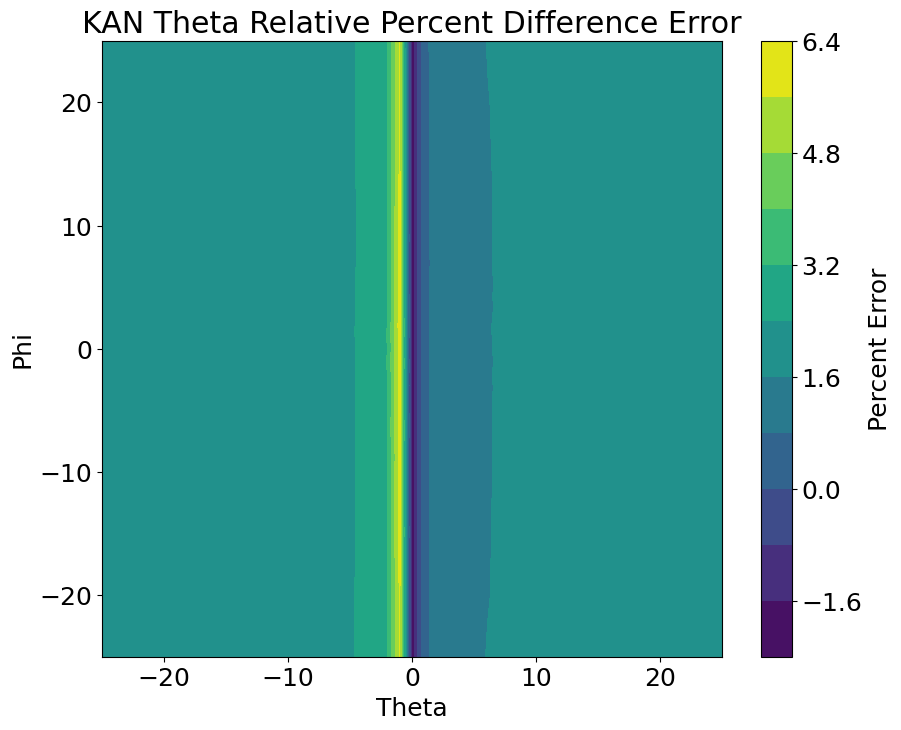

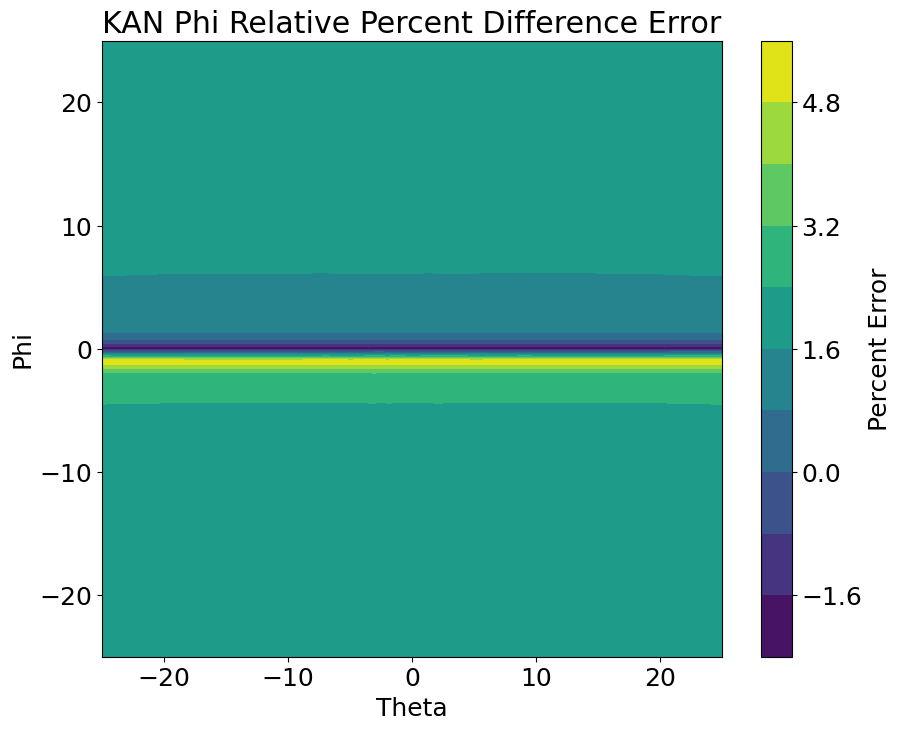

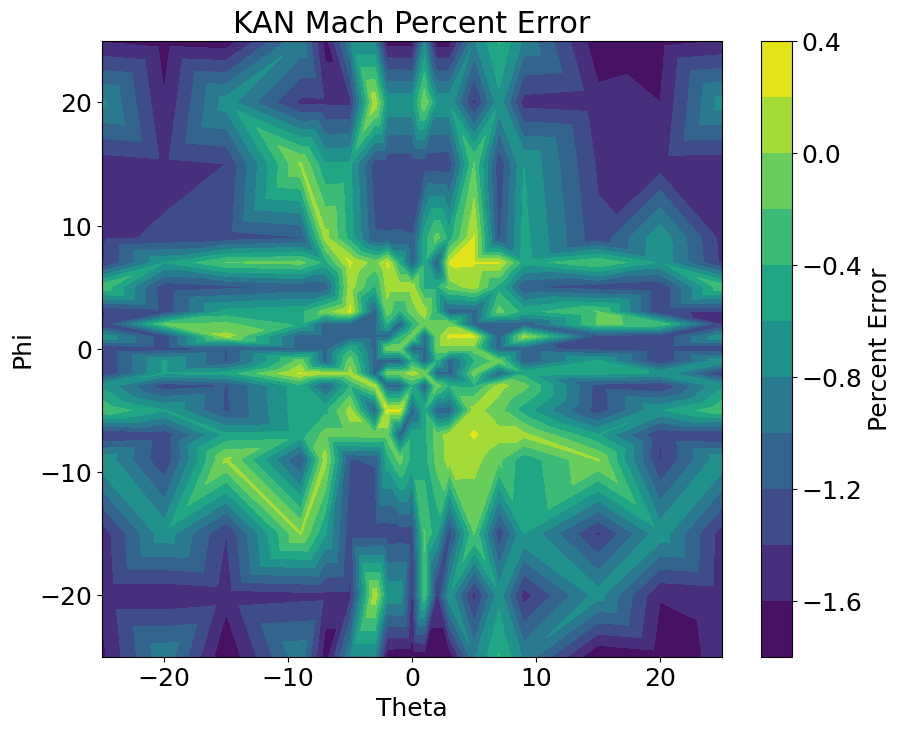

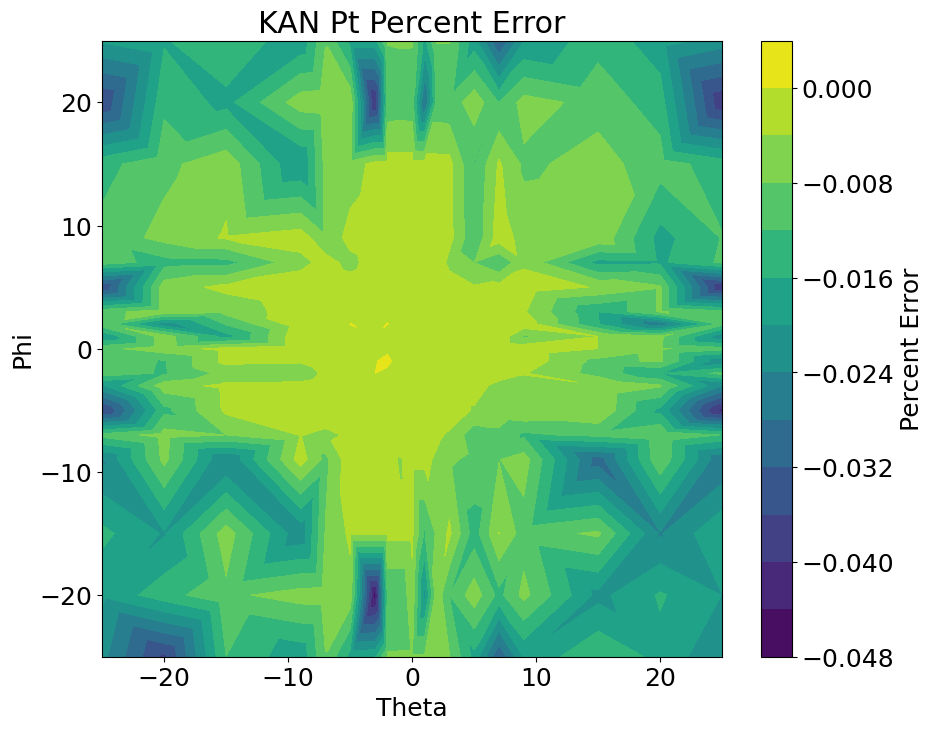

In [ ]:
df = pd.read_csv('dataset/5Hole-Probe1.csv')
probe_loc = [0,1805]
df = df.iloc[probe_loc[0]:probe_loc[1]]
FAP2 = df['FAP2'].values	# Hole 5, Center Hole
FAP3 = df['FAP3'].values	# Hole 1
FAP4 = df['FAP4'].values    # Hole 2
FAP5 = df['FAP5'].values    # Hole 3
FAP6 = df['FAP6'].values    # Hole 4
Ps = df['PSFJ'].values

nn_out1,nn_out2,kan_out1,kan_out2 = predict_data(FAP2,FAP3,FAP4,FAP5,FAP6,Ps)

plot(nn_out1,nn_out2,'Multi-Layer Perception')
plot(kan_out1,kan_out2,'KAN')

## Output of Predict Data

In [ ]:
nn_out1,nn_out2,kan_out1,kan_out2 = predict_data(FAP2,FAP3,FAP4,FAP5,FAP6,Ps)

nnout_1 is the same as kan_out1
- This data contains theta,phi


nnout_2 is the same as kan_out2
- This data contains the mach and cpt coefficient 

In [ ]:

print(nn_out1)